In [5]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


#hide
from fastbook import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [6]:
# 이미 다운로드한 데이터셋의 경로를 얻어오기
from fastai.vision.all import *

path = untar_data(URLs.PETS)

In [7]:
#hide
Path.BASE_PATH = path

# 데이터셋에 포함된 내용 확인
# - 데이터셋에 images, annotionas 디렉토리가 포함되어 있음
# - annotionas 디렉토리가 반려동물의 품종이 아닌 이미지 내 해당 동물이 위치한 좌표 정보를 담고 있음
path.ls()

(#2) [Path('annotations'),Path('images')]

In [8]:
# images 디렉토리만 확인하기
(path/"images").ls()

(#7393) [Path('images/basset_hound_24.jpg'),Path('images/great_pyrenees_42.jpg'),Path('images/Egyptian_Mau_63.jpg'),Path('images/havanese_141.jpg'),Path('images/leonberger_157.jpg'),Path('images/english_setter_167.jpg'),Path('images/english_setter_116.jpg'),Path('images/leonberger_91.jpg'),Path('images/basset_hound_90.jpg'),Path('images/saint_bernard_84.jpg')...]

In [9]:
fname = (path/"images").ls()[0]

In [10]:
# 파일명에서 품종을 추출하는 정규 표현식 만듦
# findall 메서드로 fname 객체의 파일명 속성인 nam에 정규 표현식을 적용함
# 마지막 밑줄 문자 다음에 하나 이상의 숫자와 JPEG 확장자가 등장하면 마지막 밑줄 문자 이전의 모든 문자열을 추출함
re.findall(r'(.+)_\d+.jpg$', fname.name)

['basset_hound']

In [11]:
# 전체 데이터셋 레이블링에도 적용해보기
# fastai는 정규 표현식을 이용해 레이블링 작업을 할 수 있도록 RegexLabeller 클래스를 제공함
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = RandomSplitter(seed=42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")


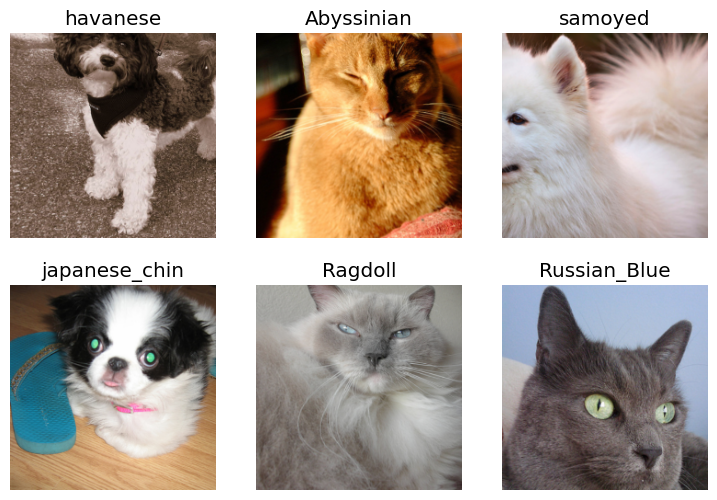

In [12]:
# 데이터블록 검사와 디버깅
# - 템플릿만으로는 실제 데이터에서 의도한 대로 작동한다고 보장할 수 없음
# - 따라서, 모델을 학습시키기 전 데이터블록이 정상적으로 작동하는지를 항상 점검해야만 함

dls.show_batch(nrows=2, ncols=3)

In [13]:
#hide_output
from fastai.vision.all import *

pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg'), 'name'),
                 item_tfms=Resize(224)) # Add Resize transform to ensure consistent image size

pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_161.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_161.jpg
    applying partial gives
      yorkshire_terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(36)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(36))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False

In [14]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 81.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.516607,0.346880,0.110961,01:27


epoch,train_loss,valid_loss,error_rate,time
0,0.507455,0.338318,0.105548,01:25
1,0.327153,0.239882,0.073748,01:20


In [15]:
x, y = dls.one_batch() # 실제 배치 하나 조회
y # 종속변수 내용확인

TensorCategory([11, 10, 10, 32,  2, 32, 17, 35, 11, 33,  4,  9, 21, 26, 24, 23,  8, 19,  5, 18, 34,  3,  8, 23,  5, 31, 18, 22,  3, 11,  6, 24, 18, 10,  6, 14, 10,  8, 35,  8, 24, 26, 17, 24,  0, 26,
                26,  4,  5,  0, 14, 18, 12, 13, 24, 27, 32,  2, 19,  9, 28,  9, 30,  5], device='cuda:0')

In [16]:
preds, _ = learn.get_preds(dl=[(x, y)]) # 예측값 조회
preds[0]

tensor([5.6468e-05, 4.0422e-06, 8.3709e-08, 7.2861e-07, 2.0650e-07, 8.4865e-07, 2.0919e-07, 1.0114e-08, 9.0124e-08, 2.3231e-05, 5.2828e-06, 9.9977e-01, 1.3153e-05, 1.7040e-06, 3.6993e-07, 6.6837e-06,
        8.7334e-07, 1.0209e-04, 7.0129e-07, 3.9294e-07, 8.7850e-07, 1.3587e-08, 3.3888e-07, 4.3383e-07, 1.4653e-07, 3.9181e-09, 5.6068e-06, 3.1025e-09, 5.0628e-08, 6.5574e-07, 3.4888e-08, 1.4291e-07,
        2.0075e-06, 2.8413e-07, 2.5080e-07, 2.3397e-08, 1.6010e-06])

In [17]:
# 예측은 0~1 범위의 확률 37개로 구성
# 그리고 이 값 37개를 모두 더 하면 1이 나와야함
len(preds[0]), preds[0].sum()

(37, tensor(1.))

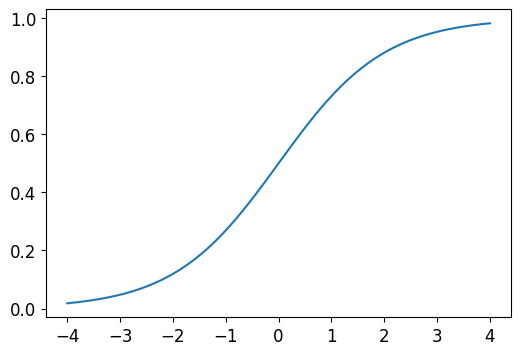

In [18]:
# 소프트맥스(시그모이드 함수와 유사함)
# 시그모이드 함수는 아래와 같음
plot_function(torch.sigmoid, min=-4, max=4)

In [19]:
# 출력 활성이 표준 편차가 2인 임의의 숫자라고 가정
# 즉, 아래 코드의 acts가 두 범주 중 하나에 속하는 이미지 여섯 장을 표현한다고 생각해보기

acts = torch.randn((6, 2)) * 2
acts

tensor([[-2.7469,  1.2929],
        [-3.3264, -0.6674],
        [-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076],
        [ 2.2148, -2.0914]])

In [20]:
acts.sigmoid()

tensor([[0.0603, 0.7846],
        [0.0347, 0.3391],
        [0.2179, 0.7787],
        [0.7645, 0.9280],
        [0.1674, 0.0353],
        [0.9016, 0.1099]])

In [21]:
(acts[:, 0] - acts[:,1]).sigmoid()

tensor([0.0173, 0.0654, 0.0734, 0.2011, 0.8459, 0.9867])

In [22]:

# 위와 같은 일을 하는 것이 바로 소프트맥스함수임
def softmax(x) :
  return exp(x) / exp(x).sum(dim=1, keepdim=True)

sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

In [23]:
import torch

# 로그 가능도
def mnist_loss(inputs, targets) :
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).mean()

targ = torch.tensor([0, 1, 0, 1, 1, 0])
sm_acts

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

In [24]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.0173, 0.9346, 0.0734, 0.7989, 0.1541, 0.9867])

In [25]:
-sm_acts[idx, targ]

tensor([-0.0173, -0.9346, -0.0734, -0.7989, -0.1541, -0.9867])

In [26]:
F.nll_loss(sm_acts, targ, reduction='none') # NLL은 음의 로그 가능도를 뜻함

tensor([-0.0173, -0.9346, -0.0734, -0.7989, -0.1541, -0.9867])

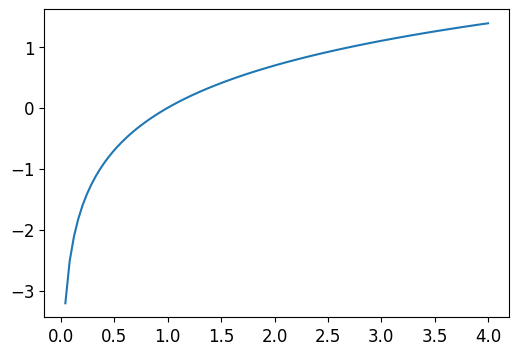

In [27]:
# 로그 취하기
# - 모델은 예측값이 0.99일 때와 0.999일 때의 차이를 잘 다루지 못함
# - 두 수는 매우 근접하지만, 다른 시각에서 보면 0.999는 0.99보다 신뢰도가 10배나 높다고 해석할 수 있음
# - 이를 해결하려면 0~1 사이의 값을 음의 무한대와 양의 무한대로 변환해야함
# - 이를 위해 사용하는 것이 '로그'

plot_function(torch.log, min=0, max=4)

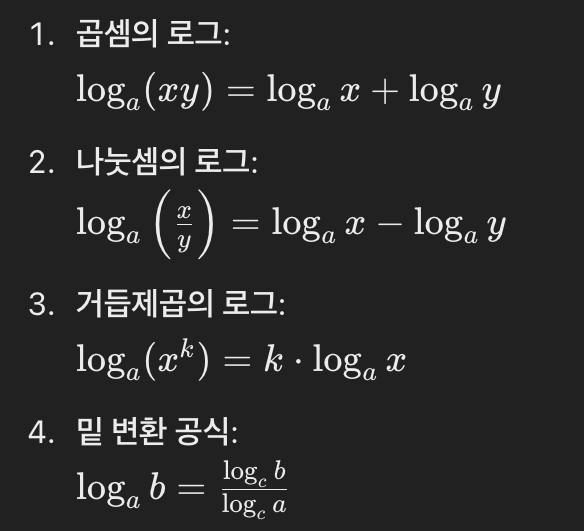

In [31]:
loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.4743)

In [32]:
F.cross_entropy(acts, targ)

tensor(1.4743)

In [35]:
# 기본적으로 파이토치의 손실 함수는 모든 항목의 평균 손실을 계산함
# - reduce = 'none' 옵션을 사용하면 이런 행동을 비활성화 할 수 있음
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([4.0573, 0.0677, 2.6122, 0.2245, 1.8704, 0.0134])

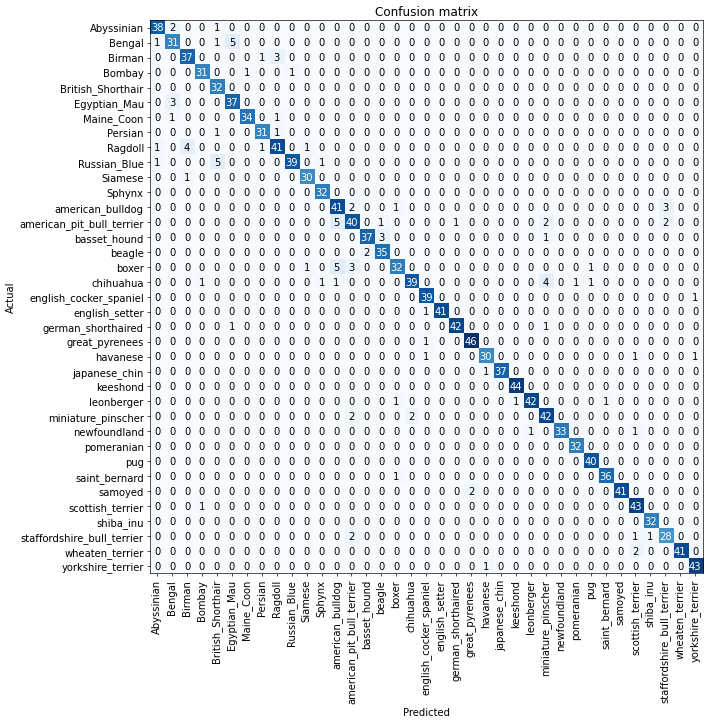

In [36]:
# 모델 해석
# - 손실 함수는 사람이 보려고 만든 것이 아니라 컴퓨터가 미분을 구하려고 최적화할 수 있도록 설계됨
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [37]:
interp.most_confused(min_val=5) # 해당 메서드를 통해 오차 행렬 중 가장 올바르지 못한 예측만 확인하기

[('Bengal', 'Egyptian_Mau', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5),
 ('boxer', 'american_bulldog', 5)]

In [40]:
# 모델 향상하기
# - 모델의 학습 능력을 개선하고 성능을 높이는 다양한 기법을 살펴봄
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.573779,3.381810,0.378214,01:19


epoch,train_loss,valid_loss,error_rate,time
0,3.256270,1.594734,0.489175,01:33


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

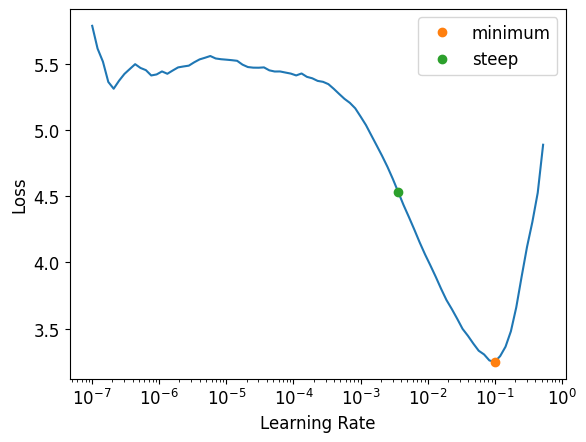

In [42]:
# 학습률 발견자
# - 다루기 크다는 생각이 전혀 들지 않을 만큼 매우 작은 학습률부터 사용하자는 아이디어
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [43]:
print(f'Minimum/10: {lr_min:.2e}. steepest point: {lr_steep:.2e}')

Minimum/10: 1.00e-02. steepest point: 3.63e-03


In [44]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.329501,0.336066,0.115697,01:20


epoch,train_loss,valid_loss,error_rate,time
0,0.557276,0.459176,0.125846,01:20
1,0.326783,0.249268,0.077808,01:34


In [45]:
# 동결 해제 및 전이 학습
# - 옵티마이저는 추가된 계층의 임의 가중치만 갱신하고, 그 외의 가중치는 전혀 바꾸지 않도록 강제할 수 있음
# - 이를 사전 학습된 계층을 '동결'시키는 기법이라고 함

In [46]:
learn.fine_tune??

In [47]:
# fit_one_cycle에서는 전체 학습을 두 부분으로 나눔
# 우선 낮은 학습률로 학습을 시작하여 첫 번째 부분까지 점진적으로 학습률을 증가시키고 두 번째 부분에서는 다시 점진적으로 학습률을 감소시킴
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.166830,0.360270,0.112991,01:21
1,0.506098,0.260572,0.085250,01:23
2,0.318239,0.236854,0.073748,01:12


In [48]:
learn.unfreeze() # 동결 해제
learn.lr_find() # 학습할 계층이 더 많아졌고 세 에포크 동안 학습된 일부 가중치가 있으니 앞서 찾은 학습률이 더는 적절치 못하기 때문

In [49]:
learn.fit_one_cycle(6, lr_max=1e-5) # 적당한 학습률로 학습 시도

epoch,train_loss,valid_loss,error_rate,time
0,0.236744,0.228434,0.075778,01:39
1,0.244080,0.224178,0.073748,01:26
2,0.232074,0.223255,0.074425,01:22
3,0.214296,0.219874,0.073748,01:14
4,0.188043,0.215591,0.071042,01:19
5,0.186038,0.213273,0.070365,01:27


In [52]:
# 차별적 학습률
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4)) # 미세 조정이 잘 작동함

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.165956,0.336208,0.107578,01:23
1,0.521025,0.284582,0.094046,01:18
2,0.329625,0.246232,0.077808,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.254870,0.243024,0.079161,01:15
1,0.262395,0.230374,0.074425,01:20
2,0.239901,0.217502,0.070365,01:14
3,0.207572,0.221172,0.070365,01:20
4,0.196941,0.214796,0.071719,01:14
5,0.167710,0.205801,0.062923,01:17
6,0.174869,0.204734,0.064276,01:16
7,0.160039,0.206661,0.063599,01:17
8,0.143221,0.202812,0.065629,01:16
9,0.134711,0.201346,0.065629,01:16


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

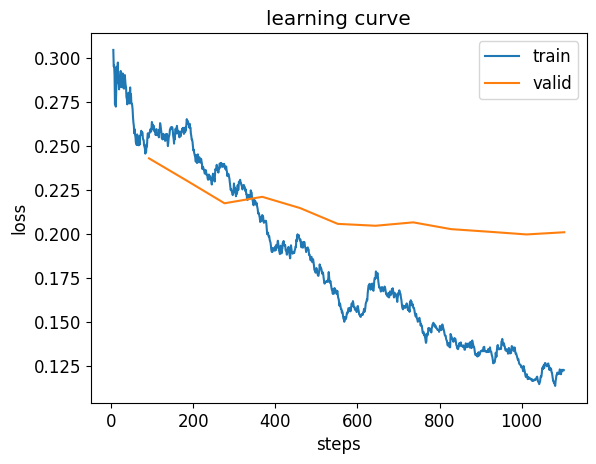

In [53]:
# 밑에 그림을 보면
# 학습용 데이터셋 손실이 계속해서 나아지는 모습임
# 그러나 검증용 데이터셋 손실의 개선은 매우 더딘 편임
learn.recorder.plot_loss()

In [54]:
from fastai.callback.fp16 import *

learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler

epoch,train_loss,valid_loss,error_rate,time
0,2.210919,0.466389,0.142084,01:15
1,0.852756,0.310795,0.098782,01:10
2,0.553249,0.300828,0.097429,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.291620,0.219278,0.067659,01:14
1,0.258467,0.223254,0.068336,01:17
2,0.203711,0.233947,0.067659,01:12
3,0.139552,0.203242,0.063599,01:17
4,0.086746,0.192761,0.058187,01:12
5,0.066386,0.196680,0.052774,01:13


# 여기서 다룬 내용

### - 데이터를 준비하는 방법 : 사전 크기 조절, 데이터블록 요약
### - 모델을 학습시키는 방버 : 학습률 발견자, 동결 해제, 차별적 학습률, 에포크 횟수 설정, 더 깊은 구조 사용
### - 교차 엔트로피 손실